# Imports

In [269]:
%pip install torchcde

In [271]:
%pip install nengolib

In [273]:
%pip install torchdyn

In [1]:
#!g1.1
import os
import torchcde
import torch
import tensorboard
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers


from node.models import EegNet, OdeLstm, LmuLstm,  NeuralCde
from node.runners.base import Learner


In [2]:
#!g1.1
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from node.dataset import P300Dataset

In [3]:
#!g1.1
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torch.optim import Adam

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np

### Import P300

In [4]:
#!g1.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
ds = P300Dataset().get_data()

In [6]:
# #!g1.1

# Datasphere
# ds = torch.load('demons.pt')

In [39]:
#!g1.1
X, y = ds[0], ds[1]

## Data visualization

In [40]:
p300_true = X[y>0]

In [41]:
p300_false = X[y<1][:len(p300_true)]

In [42]:
mean_true = torch.mean(p300_true, axis=0)
mean_false = torch.mean(p300_false, axis=0)

In [71]:
ch_names = ["Cz", "P3", "Pz", "P4", "PO3", "PO4", "O1", "O2"]

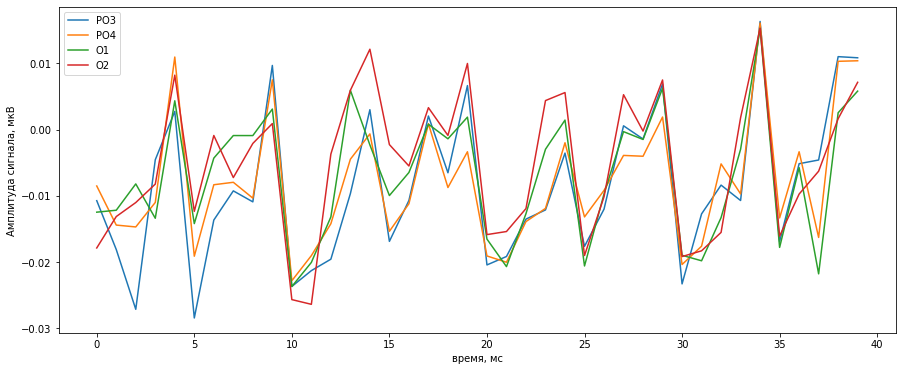

In [77]:
plt.figure(figsize=(15, 6))
for i in range(4, 8):
    plt.plot(np.arange(40), mean_true.permute(1, 0)[i], label=ch_names[i])
ax = plt.gca()
ax.set_xlabel('время, мс')
ax.set_ylabel('Амплитуда сигнала, мкВ')
plt.legend()
plt.show()

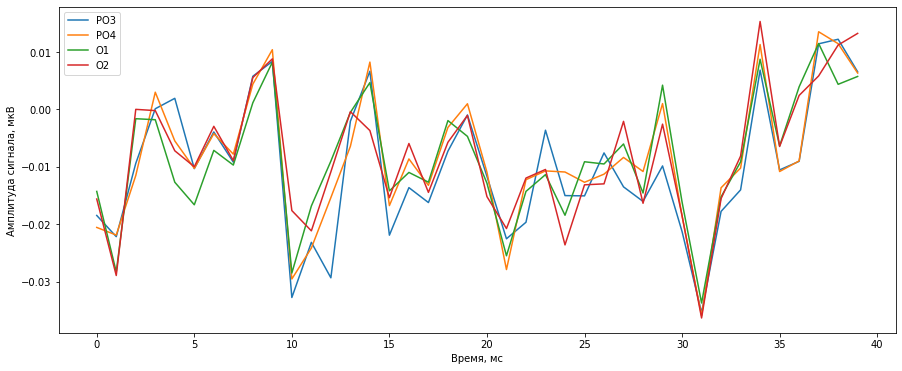

In [76]:
plt.figure(figsize=(15, 6))
for i in range(4, 8):
    plt.plot(np.arange(40), mean_false.permute(1, 0)[i], label=ch_names[i])
ax = plt.gca()
ax.set_xlabel('Время, мс')
ax.set_ylabel('Амплитуда сигнала, мкВ')
plt.legend()
plt.show()

In [59]:
mean_true.permute(1, 0)[4:]

tensor([[-0.0107, -0.0181, -0.0271, -0.0046,  0.0027, -0.0285, -0.0137, -0.0093,
         -0.0109,  0.0097, -0.0237, -0.0213, -0.0196, -0.0097,  0.0030, -0.0169,
         -0.0107,  0.0020, -0.0065,  0.0066, -0.0204, -0.0192, -0.0135, -0.0121,
         -0.0036, -0.0176, -0.0120,  0.0006, -0.0014,  0.0069, -0.0233, -0.0127,
         -0.0084, -0.0107,  0.0163, -0.0169, -0.0052, -0.0046,  0.0110,  0.0108],
        [-0.0085, -0.0144, -0.0147, -0.0110,  0.0109, -0.0191, -0.0083, -0.0080,
         -0.0104,  0.0075, -0.0228, -0.0190, -0.0142, -0.0045, -0.0007, -0.0154,
         -0.0112,  0.0009, -0.0088, -0.0034, -0.0191, -0.0200, -0.0139, -0.0119,
         -0.0020, -0.0132, -0.0092, -0.0039, -0.0040,  0.0019, -0.0204, -0.0176,
         -0.0052, -0.0097,  0.0161, -0.0133, -0.0034, -0.0163,  0.0103,  0.0104],
        [-0.0125, -0.0122, -0.0082, -0.0134,  0.0043, -0.0142, -0.0043, -0.0009,
         -0.0009,  0.0031, -0.0237, -0.0201, -0.0132,  0.0059, -0.0023, -0.0100,
         -0.0065,  0.0008,

In [60]:
mm_true = torch.mean(mean_true.permute(1, 0)[4:], axis=0)
mm_false = torch.mean(mean_false.permute(1, 0)[4:], axis=0)

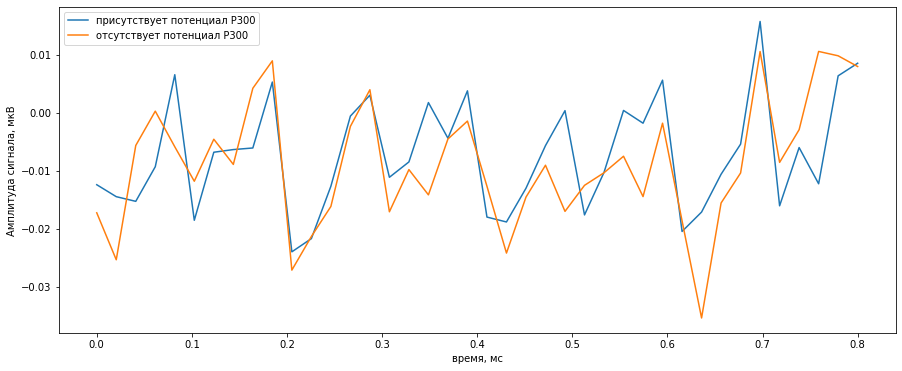

In [78]:
plt.figure(figsize=(15, 6))
plt.plot(np.linspace(0, 0.8, 40), mm_true, label='присутствует потенциал P300')
plt.plot(np.linspace(0, 0.8, 40), mm_false, label='отсутствует потенциал P300')
ax = plt.gca()
ax.set_xlabel('время, мс')
ax.set_ylabel('Амплитуда сигнала, мкВ')
plt.legend()
plt.show()

## Preparing data

In [ ]:
#!g1.1
X, y = ds[0][:15000], ds[1][:15000]

In [8]:
#!g1.1
X_T = X.permute(0, 2, 1)

In [9]:
#!g1.1
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify = y)

In [10]:
#!g1.1
#transpose split
X_train_T, X_test_T, y_train_T, y_test_T = train_test_split(X_T, y, test_size=0.20, random_state=42, stratify = y)

In [135]:
plt.figure(figsize=(15, 6))
for i in range(2):
    plt.plot(np.arange(40), X_train[10][i])
plt.show()

In [42]:
#!g1.1
train = data.TensorDataset(X_train, y_train)
test = data.TensorDataset(X_test, y_test)

In [43]:
#!g1.1
trainloader = data.DataLoader(train, batch_size=128, shuffle=True, num_workers=4)
testloader = data.DataLoader(test, batch_size=128, shuffle=False, num_workers=4)



In [44]:
#!g1.1
train_T = data.TensorDataset(X_train_T, y_train_T)
test_T = data.TensorDataset(X_test_T, y_test_T)

In [45]:
#!g1.1
trainloader_T = data.DataLoader(train_T, batch_size=128, shuffle=True, num_workers=4)
testloader_T = data.DataLoader(test_T, batch_size=128, shuffle=False, num_workers=4)



In [46]:
#!g1.1
counts = y_test.unique(return_counts=True)[1].to(torch.float)
class_balance = counts / counts.min()

In [47]:
#!g1.1
class_balance = class_balance.to(device)

# EegNet

In [ ]:
#!g1.1
checkpoint_callback = ModelCheckpoint(
    monitor='val_f1',
    mode = 'max',
    dirpath='logs/models/demons/EEGNET/',
    save_top_k = 3,
)

In [36]:
#!g1.1
eegnet = EegNet(
    input_size =(X_T.shape[1], X_T.shape[2]), #количество электродов = 8 и количество временных отрезков = 40
    rate = 50,
    F1 = 2,
    D = 4,
).to(device)

In [37]:
#!g1.1
learn = Learner(eegnet, lr=0.05, timestamps=False, class_weights = (1/class_balance).to(device))

In [48]:
#!g1.1
trainer = pl.Trainer(
    max_epochs=10,
    progress_bar_refresh_rate=1,
    gradient_clip_val=1,
    #callbacks=[checkpoint_callback]
    gpus=1
)
trainer.fit(learn, trainloader_T, val_dataloaders = testloader_T)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | model    | EegNet   | 392   
1 | accuracy | Accuracy | 0     
2 | f1       | F1       | 0     
--------------------------------------
392       Trainable params
0         Non-trainable params
392       Total params
0.002     Total estimated model params size (MB)


In [25]:
#!g1.1
results = trainer.test(learn, testloader_T)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': 0.8019999861717224,
 'val_f1': 0.7144409418106079,
 'val_loss': 0.9721020460128784}
--------------------------------------------------------------------------------



# CDE

In [19]:
#!g1.1
t = torch.arange(
            0.0,
            0.8,
            0.8 / X.size(1),  # (self.end_epoch-self.start_epoch)/all_x.size(1),
            dtype=torch.float32,
        )


In [20]:
#!g1.1
t = torch.stack([t] * X.size(0))[:, :, None]

In [23]:
#!g1.1
X_t = torch.cat([t, X], dim=2)

In [24]:
#!g1.1
X_t.shape

torch.Size([15000, 40, 9])

In [25]:
#!g1.1
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, y, test_size=0.25, random_state=42, stratify = y)

In [26]:
#!g1.1
X_train_t.shape

torch.Size([11250, 40, 9])

In [27]:
#!g1.1
X_train_cubic, X_test_cubic = torchcde.natural_cubic_coeffs(X_train_t), torchcde.natural_cubic_coeffs(X_test_t) 

In [28]:
#!g1.1
train = data.TensorDataset(X_train_cubic, y_train_t)
test = data.TensorDataset(X_test_cubic, y_test_t)

In [29]:
#!g1.1
trainloader = data.DataLoader(train, batch_size=128, shuffle=True, num_workers=4)
testloader = data.DataLoader(test, batch_size=128, shuffle=False, num_workers=4)

In [30]:
#!g1.1
cde_model = NeuralCde(input_channels=9,          #разменость исходного пространства, 8 кол-во электродов + время
                      hidden_channels=10,        #размерность скрытого пространства модели  
                      output_channels=2).to(device)

In [31]:
#!g1.1
cde_model

NeuralCde(
  (func): CDEFunc(
    (linear1): Linear(in_features=10, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=90, bias=True)
  )
  (initial): Linear(in_features=9, out_features=10, bias=True)
  (readout): Linear(in_features=10, out_features=2, bias=True)
)

In [32]:
#!g1.1
learn = Learner(cde_model, lr=0.05, timestamps=False, class_weights = (1/class_balance).to(device))

In [35]:
#!g1.1
trainer = pl.Trainer(
    max_epochs=5,
    progress_bar_refresh_rate=1,
    gradient_clip_val=0,
    #callbacks=[checkpoint_callback],
    #logger = tb_logger,
    #log_every_n_steps=1,
    val_check_interval=0.1,
    gpus=1
    
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [36]:
#!g1.1
trainer.fit(learn, trainloader, val_dataloaders = testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type      | Params
---------------------------------------
0 | model    | NeuralCde | 13.1 K
1 | accuracy | Accuracy  | 0     
2 | f1       | F1        | 0     
---------------------------------------
13.1 K    Trainable params
0         Non-trainable params
13.1 K    Total params
0.053     Total estimated model params size (MB)


In [37]:
#!g1.1
results = trainer.test(learn, testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': 0.7450666427612305,
 'val_f1': 0.7102492451667786,
 'val_loss': 0.9169046878814697}
--------------------------------------------------------------------------------

